In [1]:
!pip install fastai
!pip install kaggle

  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=c0d9259b9181c7f72fd1b212cfa369686785093feee7414864ce1e010d27c6c7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7f/26/a3/33f2079871e2bebb3f53a2b21c3ec64129b8efdd18a6263a52
Successfully built nvidia-ml-py3
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 58 kB 925 kB/s eta 0:00:011
     |████████████████████████████████| 118 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.2 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=7ce7313a2446060c4d8d43e2f9a987e7fdacee376ed1f79b3eb7c23f7e6bacf4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.w

In [2]:
!mkdir ~/.kaggle

1.  Go to your account page in kaggle and go to the API section.
2.  In the API section select Create New API Token.
3.  Copy the contents of the downloaded file and place it in the ../../.kaggle/kaggle.json file

In [3]:
import os
if not os.path.isfile('../../.kaggle/kaggle.json'):
    !cp kaggle.json ../../.kaggle/
!chmod 600 ../../.kaggle/kaggle.json

In [10]:
import numpy as np
import pandas as pd                            
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
import sys                                        
import math                                       
import json                                       
import os                                         
import sagemaker                                  
from sagemaker.predictor import csv_serializer
import seaborn as sns

In [5]:
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/coronahack_chest_xray'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name 
smclient = boto3.Session().client('sagemaker')

In [9]:
!kaggle datasets download -p ./data praveengovi/coronahack-chest-xraydataset

coronahack-chest-xraydataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip ./data/coronahack-chest-xraydataset.zip

Archive:  ./data/coronahack-chest-xraydataset.zip
replace Chest_xray_Corona_Metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
csv_file_Metadata = 'Chest_xray_Corona_Metadata.csv'  
csv_file_Summary = 'Chest_xray_Corona_dataset_Summary.csv'

metadata_df = pd.read_csv(csv_file_Metadata)
summary_df = pd.read_csv(csv_file_Summary)
metadata_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [9]:
print(f'Number of images: {metadata_df.shape[0]}')
print(f'Number of uniqe Labels {len(metadata_df["Label"].unique())}')
print(f'Labels: {metadata_df["Label"].unique()}')
print(f'Dataset types: {metadata_df["Dataset_type"].unique()}')
training_data = metadata_df[metadata_df['Dataset_type']=='TRAIN']
test_data = metadata_df[metadata_df['Dataset_type']=='TEST']
print(f'Train data shape {training_data.shape}')
print(f'Test data shape {test_data.shape}')

Number of images: 5910
Number of uniqe Labels 2
Labels: ['Normal' 'Pnemonia']
Dataset types: ['TRAIN' 'TEST']
Train data shape (5286, 6)
Test data shape (624, 6)


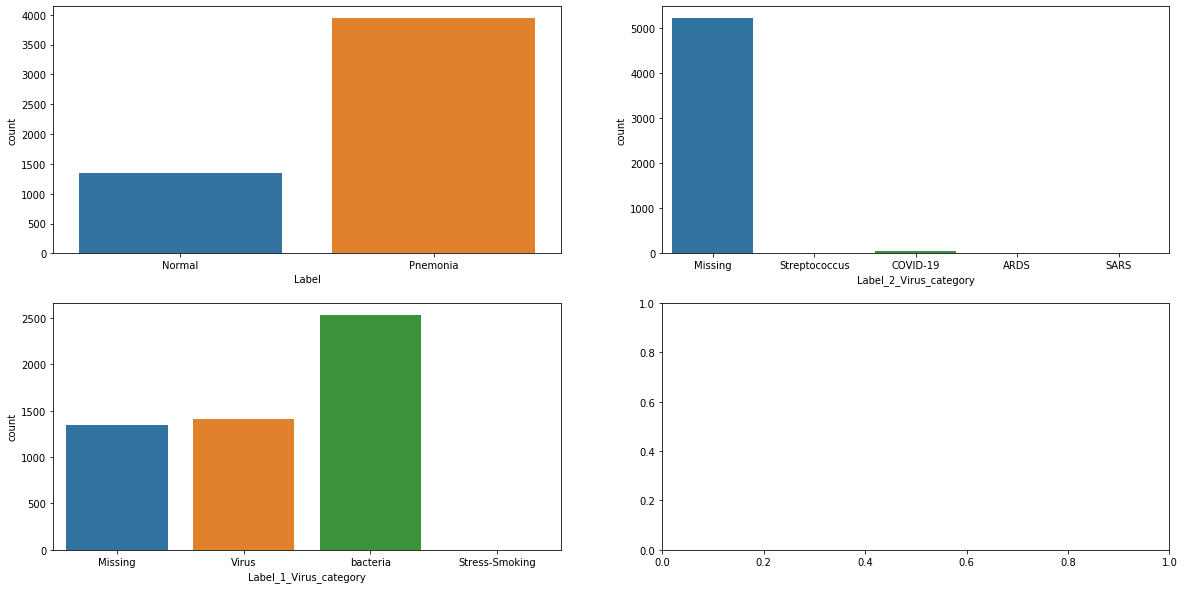

In [13]:
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig,ax=plt.subplots(2,2, figsize=(20, 10))
training_data_na = pd.DataFrame()
training_data_na['Label'] = training_data['Label'].fillna("Missing")
training_data_na['Label_2_Virus_category'] = training_data['Label_2_Virus_category'].fillna("Missing")
training_data_na['Label_1_Virus_category'] = training_data['Label_1_Virus_category'].fillna("Missing")
sns.countplot(x='Label',data=training_data_na, ax=ax[0, 0])
sns.countplot(x='Label_2_Virus_category',data=training_data_na, ax=ax[0, 1])
sns.countplot(x='Label_1_Virus_category',data=training_data_na, ax=ax[1, 0])
plt.show()

In [13]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [14]:
# should be the name of directory you created to save your features data
data_dir = 'corona_data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
!cp Chest_xray_Corona* corona_data


# set prefix, a descriptive name for a directory  
prefix = 'corona-data'
data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [15]:
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

corona-data/Chest_xray_Corona_Metadata.csv
corona-data/Chest_xray_Corona_dataset_Summary.csv
plagiarism-detection/test.csv
plagiarism-detection/train.csv
Test passed!
